###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [113]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

In [82]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [83]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [84]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
497,Croatia,2014,5.381,10.091,0.646,67.780,0.519,0.125,0.918,0.545,0.286
124,Azerbaijan,2016,5.304,9.563,0.777,63.225,0.713,-0.210,0.607,0.509,0.191
2299,Vietnam,2009,5.304,8.701,0.815,64.420,0.834,-0.083,0.838,0.481,0.190
1177,Lebanon,2005,5.491,9.571,0.796,65.100,0.703,NaN,0.945,0.558,0.292
690,France,2015,6.358,10.677,0.896,71.700,0.817,-0.145,0.641,0.740,0.215


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [85]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [86]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [87]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [88]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [89]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\kenklabnik\AppData\Local\Temp\ipykernel_41124\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


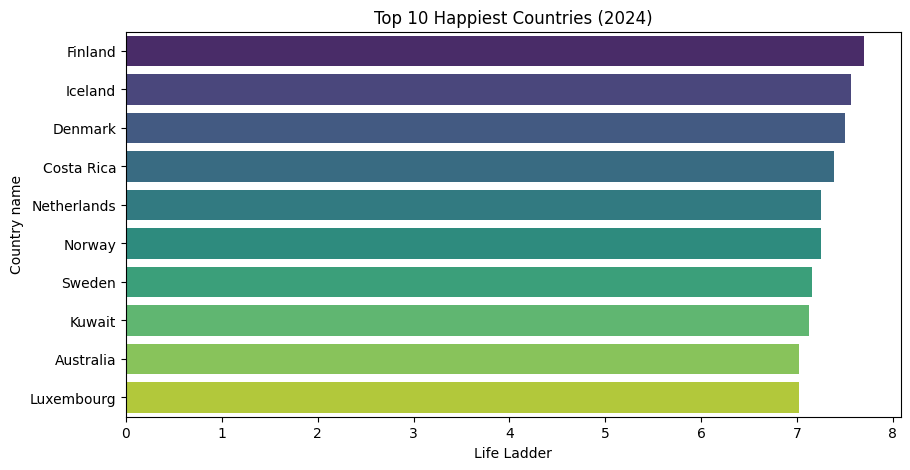

C:\Users\kenklabnik\AppData\Local\Temp\ipykernel_41124\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


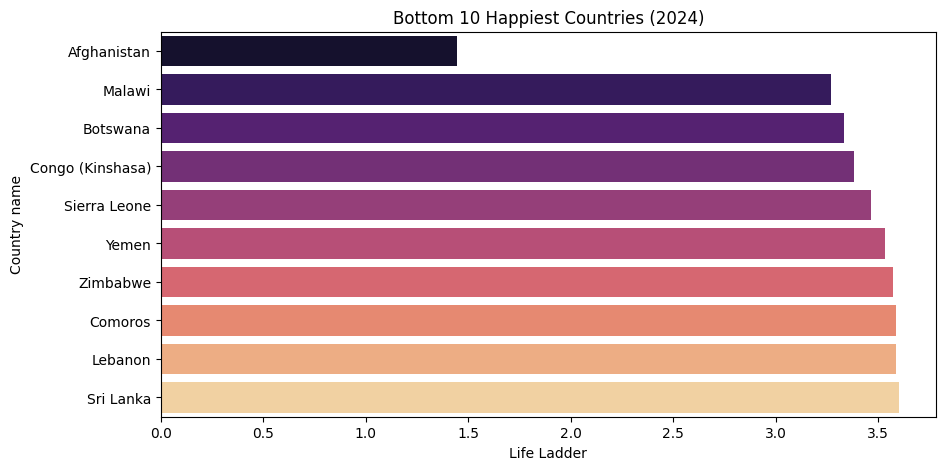

In [90]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


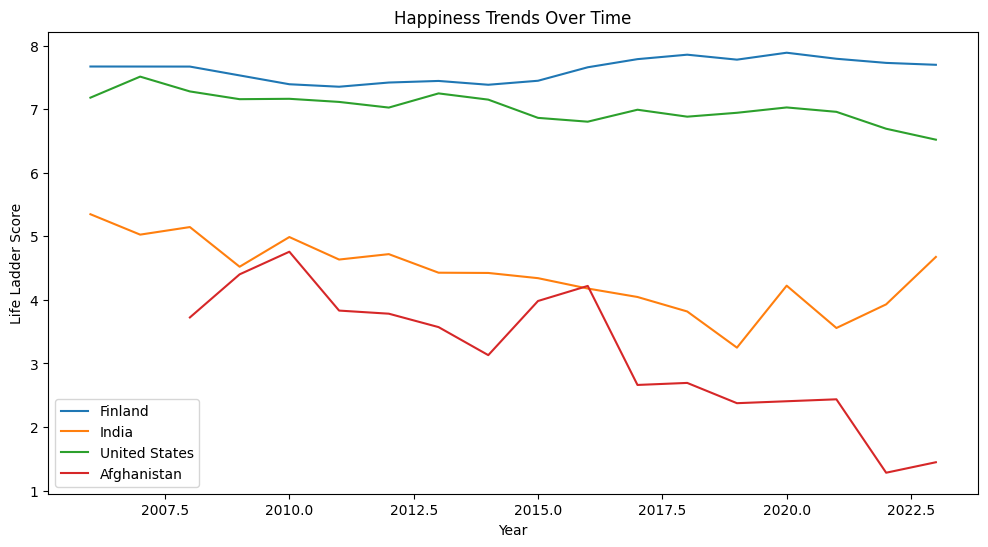

In [91]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


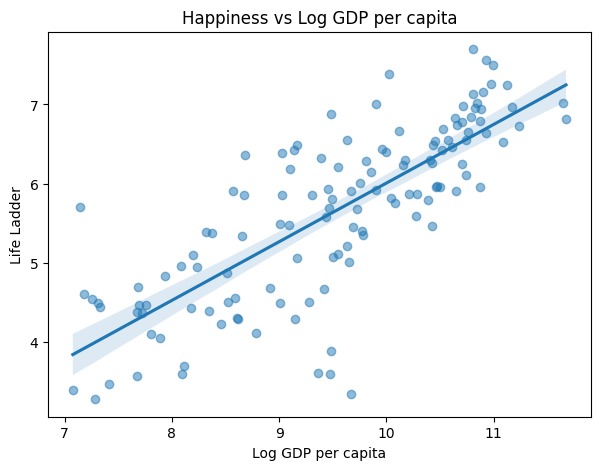

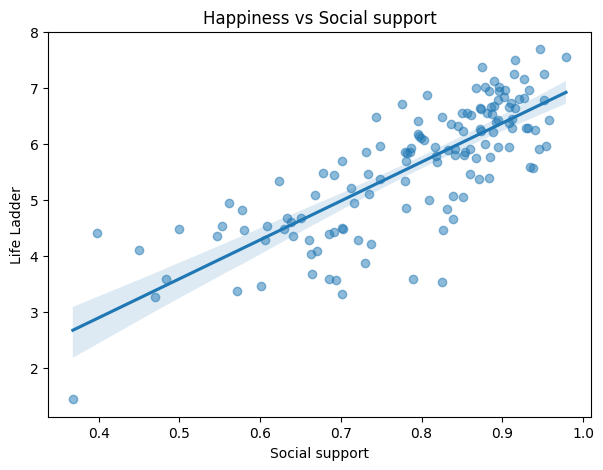

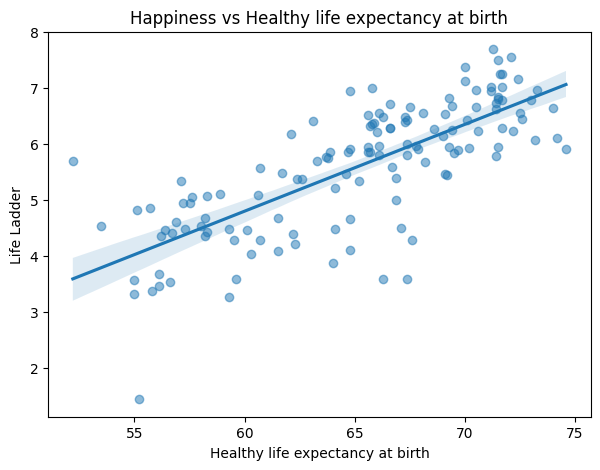

In [92]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


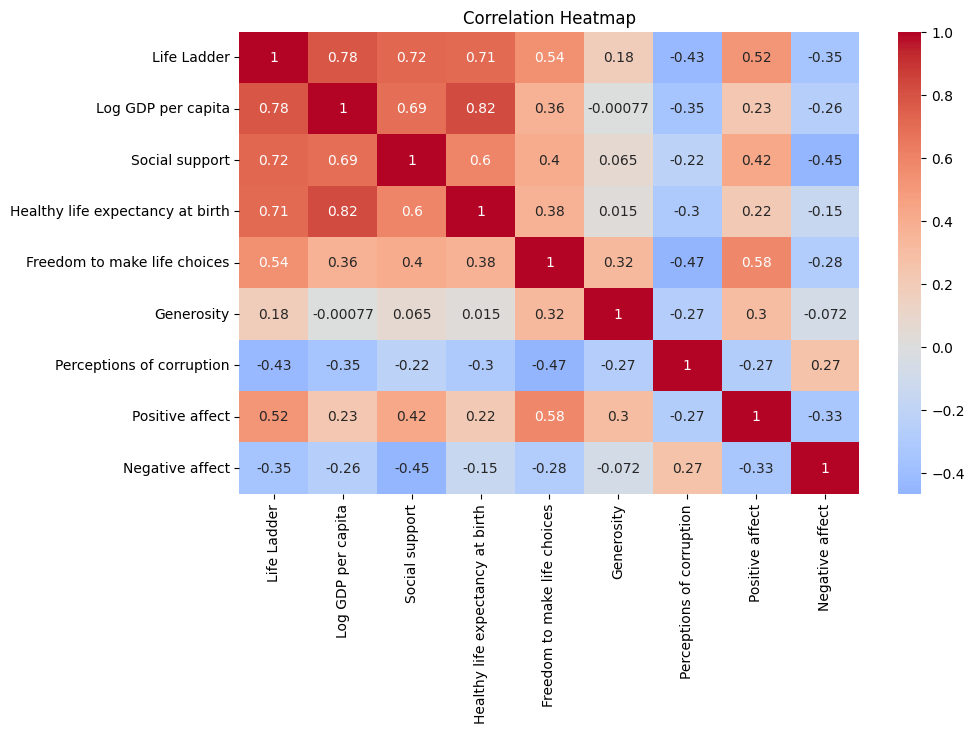

In [93]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


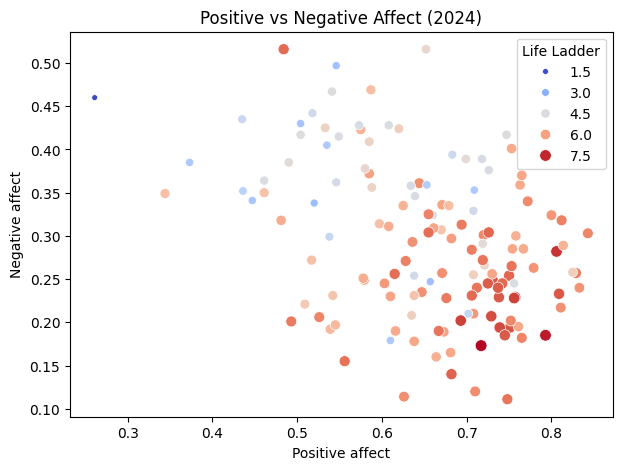

In [94]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


# Data Preprocessing and Modeling

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [96]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [97]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [98]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [99]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [100]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [101]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [102]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [103]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [104]:
data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
data.sample(10)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,country_label
2341,Zambia,2020,4.838,8.066,0.767,54.825,0.750,0.054,0.810,0.679,0.345,153
1232,Lithuania,2019,6.064,10.524,0.918,66.700,0.780,-0.258,0.783,0.568,0.276,82
1017,Ivory Coast,2022,4.849,8.619,0.536,56.525,0.713,-0.009,0.743,0.629,0.399,68
90,Australia,2016,7.250,10.781,0.942,70.675,0.922,0.233,0.399,0.736,0.236,6
696,France,2021,6.656,10.714,0.915,72.300,0.837,-0.104,0.561,0.685,0.268,47
484,Costa Rica,2017,7.225,9.912,0.922,70.000,0.936,-0.086,0.742,0.791,0.275,33
1009,Ivory Coast,2014,3.570,8.351,0.711,51.900,0.781,-0.087,0.671,0.603,0.291,68
1742,Russia,2009,5.158,10.041,0.908,60.060,0.617,-0.289,0.954,0.540,0.169,116
195,Benin,2011,3.870,7.876,0.477,53.260,0.773,-0.145,0.849,0.574,0.219,14
736,Germany,2007,6.417,10.760,0.926,69.940,0.801,0.161,0.792,0.647,0.231,51


Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [105]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      1725 non-null   object 
 1   year                              1725 non-null   int64  
 2   Life Ladder                       1725 non-null   float64
 3   Log GDP per capita                1725 non-null   float64
 4   Social support                    1725 non-null   float64
 5   Healthy life expectancy at birth  1725 non-null   float64
 6   Freedom to make life choices      1725 non-null   float64
 7   Generosity                        1725 non-null   float64
 8   Perceptions of corruption         1725 non-null   float64
 9   Positive affect                   1725 non-null   float64
 10  Negative affect                   1725 non-null   float64
 11  country_label                     1725 non-null   int16  
dtypes: float64(

In [106]:
features_train = training.drop(['Life Ladder', 'Country name'], axis=1)
features_test = test.drop(['Life Ladder', 'Country name'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [115]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.39253877967138134

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [112]:
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-09-28 14:33:34,594] A new study created in memory with name: no-name-7304615d-0faf-46a4-bb2c-2cfea60a1fb2
[I 2025-09-28 14:33:35,055] Trial 0 finished with value: 0.3503867475872948 and parameters: {'n_estimators': 120, 'max_depth': 8}. Best is trial 0 with value: 0.3503867475872948.
[I 2025-09-28 14:33:36,173] Trial 1 finished with value: 0.321076870308982 and parameters: {'n_estimators': 60, 'max_depth': 13}. Best is trial 1 with value: 0.321076870308982.
[I 2025-09-28 14:33:37,238] Trial 2 finished with value: 0.3246800009788029 and parameters: {'n_estimators': 70, 'max_depth': 12}. Best is trial 1 with value: 0.321076870308982.
[I 2025-09-28 14:33:37,824] Trial 3 finished with value: 0.34903856482203044 and parameters: {'n_estimators': 160, 'max_depth': 8}. Best is trial 1 with value: 0.321076870308982.
[I 2025-09-28 14:33:38,638] Trial 4 finished with value: 0.3278205616776905 and parameters: {'n_estimators': 70, 'max_depth': 11}. Best is trial 1 with value: 0.321076870308

In [ ]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 100, 'max_depth': 14}
At trial:  23
Mean absolute error:  0.3186673895442297

Hyperparameter importances:


{'max_depth': np.float64(0.969758872562199),
 'n_estimators': np.float64(0.03024112743780114)}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.